In [1]:
#Pkg.update()
using PyPlot
using TestImages
using ImageFeatures
using Images
using TestImages
using ImageDraw
using ImageDraw 
using Perceptron
using BenchmarkTools

In [2]:
## Param for the notebook
stride = 10

10

### About hog
- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

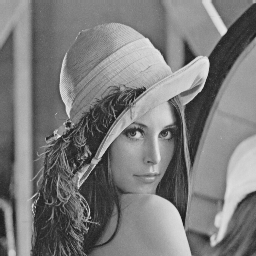

In [3]:
img = testimage("lena_gray")

In [4]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [5]:
img_as_array = convert(Array{Float32},img);

In [6]:
minimum(img_as_array), maximum(img_as_array)

(0.10196079f0, 0.9490197f0)

## HOG descriptor

- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

In [7]:
#?(HOG)

In [8]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [9]:
h = HOG(orientations=9,
        cell_size=8,
        block_size = 2,
        block_stride = 1,
        norm_method="L2-norm")

ImageFeatures.HOG(9, 8, 2, 1, "L2-norm")

In [10]:
@time hog_features = create_descriptor(img, h);

  6.282337 seconds (7.90 M allocations: 365.208 MiB, 4.65% gc time)


In [11]:
@time hog_features = create_descriptor(img, h);

  0.039072 seconds (1.50 M allocations: 27.985 MiB, 30.66% gc time)


In [12]:
size(img), size(hog_features)

((256, 256), (34596,))

### Load pedestrian data

In [13]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

In [14]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)

n_pos = length(pos_example_names)
n_neg = length(neg_example_names)

n = n_pos + n_neg                       # number of training examples 
data = Array{Float64}(3780, n)          # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n);              # Vector to store label (1=human, 0=not human) of each image.

for (i, file) in enumerate([pos_example_names ; neg_example_names])
    
    #filename = "$(i <= n_pos ? path_positive_examples : path_negative_examples)/$file"
    if i <= n_pos
        filename =  path_positive_examples * file
    else
        filename = path_negative_examples * file
    end
    
    img = load(filename)   
    if i > n_pos # negative samples are bigger, we take a patch of the same shape
        img = img[1:128, 1:64]
    end
    
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

In [15]:
println("size of the data:             ", size(data))
println("size of the labels:           ", size(labels))
println("number of negative labels:    ", sum(labels.==0))
println("number of positive labels:    ", sum(labels.==1))

size of the data:             (3780, 974)
size of the labels:           (974,)
number of negative labels:    50
number of positive labels:    924


### Generate negative samples of shape (128,64)

In [16]:
function extract_patches_2d(image, patch_size, stride)
    
    n_rows, n_cols = size(image) 
    n_rows_patch, n_cols_patch = patch_size
    patches = []
    for i in 1:stride:(n_rows - n_rows_patch)
        for j in 1:stride:(n_cols - n_cols_patch)
            push!(patches, image[i:i+n_rows_patch-1, j:j+n_cols_patch-1])
        end
    end
    
    return patches
end


extract_patches_2d (generic function with 1 method)

In [17]:
negative_patches = extract_patches_2d(neg_images[1], (128,64), 10);

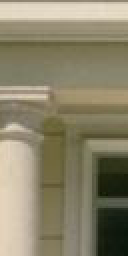

In [18]:
negative_patches[2]

In [19]:
hog_features = create_descriptor(negative_patches[1], h);
size(hog_features)

(3780,)

## Custom Hog descriptor

In [20]:
"""
Simple version
- This is not block normalized
- This does not take into account distance between the limits of the bin and the final chosen bin
"""
@inline function gradients_to_bins!(hist, magnitudes, orientations)
    n_bins = length(hist)
    T = eltype(magnitudes)
    bin_width = T(pi/n_bins)
    
    for (orientation, magnitude) in zip(orientations, magnitudes)
        local upper_bin_limit = bin_width
        for i in 1:n_bins
            if  orientation <= upper_bin_limit
                hist[i] += magnitude
                break
            end
            upper_bin_limit += bin_width
        end
    end
end


gradients_to_bins!

In [21]:
function to_gray(image)
    x = Array{ColorTypes.Gray{Float32}, 2}(image)
    return Array{Float32}(x)
end

function to_grayscale(image)
    return Array{ColorTypes.Gray{Float32}, 2}(image)
end

to_grayscale (generic function with 1 method)

In [22]:
#p = to_grayscale(aux[1])
p = negative_patches[1]
gx          = imfilter(p, centered([-1 0 1]))
gy          = imfilter(p, centered([-1 0 1]'));
magnitudes  = hypot.(gx, gy);
angles      = abs.(orientation.(gy, gx));
cell_stride = 8
cell_size   = 8
n_bins      = 9

function histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins)
    n_rows, n_cols   = size(magnitudes)
    n_rows_out       = Int(floor((n_rows - cell_size)/cell_stride)) ## Look here how to get CORRECT VALUE
    n_cols_out       = Int(floor((n_cols - cell_size)/cell_stride)) 
    output_histogram = zeros(n_rows_out, n_cols_out, n_bins)

    # for each position in the output_histogram
    # compute the hog in the original "gradient image" and store the hog there.
    # println("size magnitudes:", size(magnitudes))
    # println("size output_histogram:", size(output_histogram))
    for row in 1:n_rows_out
        for col in 1:n_cols_out
            #println("accessed row,col ", row, " ", col)
            row_input = row*cell_stride-1
            col_input = col*cell_stride-1
            gradients_to_bins!(view(output_histogram, row, col, :),
                               view(magnitudes, row_input:row_input+cell_size, col_input:col_input+cell_size),
                               view(angles, row_input:row_input+cell_size, col_input:col_input+cell_size)) 
        end
    end
    return output_histogram
end

@time outmap = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);

  0.161529 seconds (132.53 k allocations: 6.462 MiB)


In [23]:
## histogram_map is working for the patch but not for the whole image
image = load("tutorial/humans.jpg")
image       = to_grayscale(image)
gx          = imfilter(image, centered([-1 0 1]))
gy          = imfilter(image, centered([-1 0 1]'))
magnitudes  = hypot.(gx, gy)
angles      = abs.(orientation.(gy, gx))
n_rows, n_cols   = size(magnitudes)
n_rows_out       = ((n_rows - cell_size)/cell_stride) ## Look here how to get CORRECT VALUE
n_cols_out       = ((n_cols - cell_size)/cell_stride) 
outmap      = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);
length(outmap), size(outmap)

(22878, (41, 62, 9))

In [24]:
function create_histmap(image, cell_stride, cell_size, n_bins)
    image       = to_grayscale(image)
    gx          = imfilter(image, centered([-1 0 1]))
    gy          = imfilter(image, centered([-1 0 1]'))
    magnitudes  = hypot.(gx, gy)
    angles      = abs.(orientation.(gy, gx))
    hist_map    = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);
    
    return hist_map    
end

function create_histmap_vec(image, cell_stride, cell_size, n_bins)
    image       = to_grayscale(image)
    gx          = imfilter(image, centered([-1 0 1]))
    gy          = imfilter(image, centered([-1 0 1]'))
    magnitudes  = hypot.(gx, gy)
    angles      = abs.(orientation.(gy, gx))
    hist_map    = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);
    
    return reshape(hist_map, length(hist_map))    
end

create_histmap_vec (generic function with 1 method)

In [25]:
image = negative_patches[1]
features = create_histmap_vec(image, cell_stride, cell_size, n_bins);
length(features)

945

In [26]:
x=1
y=1
img = load("tutorial/humans.jpg")
patch_size = size(pos_images[1])
n_row_patch, n_col_patch = patch_size

(128, 64)

In [27]:
cell_stride = 8
cell_size   = 8
n_bins      = 9

9

In [28]:
p = img[x:x+n_row_patch-1, y:y+n_col_patch-1]
@time features = create_histmap_vec(p, cell_stride, cell_size, n_bins);

  0.001175 seconds (708 allocations: 1.593 MiB)


In [29]:
@time features = create_histmap_vec(p, cell_stride, cell_size, n_bins);

  0.000967 seconds (708 allocations: 1.593 MiB)


In [30]:
@time features_original = create_descriptor(p, HOG());

  0.009386 seconds (101.27 k allocations: 4.673 MiB)


#### Get Dataset

In [31]:
features = create_histmap_vec(p, cell_stride, cell_size, n_bins);
length(features), length(features_original)

(945, 3780)

In [32]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"

pos_example_names = readdir(path_positive_examples)
n_pos = length(pos_example_names)
n_feat = length(features)

data = Array{Float64}(n_feat, n_pos)  # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n_pos);      # Vector to store label (1=human, 0=not human) of each image.

@time for (i, file) in enumerate(pos_example_names)
    filename =  path_positive_examples * file
    img = load(filename)   
    data[:, i] = create_histmap_vec(img, cell_stride, cell_size, n_bins);
    labels[i] = 1
end

  1.519940 seconds (831.46 k allocations: 1.467 GiB, 10.93% gc time)


In [33]:
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
neg_example_names = readdir(path_negative_examples);
size_patch = size(pos_images[1])
n_neg_samples = length(neg_example_names)
stride_samples = 30
@time begin
    for (i, file) in enumerate(neg_example_names)
        print("Generating negative patches from: $i out of $n_neg_samples  \r")
        
        filename =  path_negative_examples * file
        img = load(filename)   

        # For each negative images we extract several patches
        patches = extract_patches_2d(img, size_patch, stride_samples);

        for patch in patches
            data = hcat(data, create_histmap_vec(patch, cell_stride, cell_size, n_bins);)
            push!(labels,0);
        end
    end
end

 21.281081 seconds (1.32 M allocations: 24.976 GiB, 24.57% gc time)


In [34]:
size(data), size(labels)

((945, 2674), (2674,))

In [35]:
println("Number of non pedestrian samples: ", sum(labels.==0))
println("Number of pedestrian samples:     ", sum(labels.==1))

Number of non pedestrian samples: 1750
Number of pedestrian samples:     924


# Model with Perceptron

#### TODO:
- Missing `tutorial/humans.jpg`


In [36]:
#Pkg.clone("https://github.com/davidbp/Perceptron.jl")

In [37]:
model_stride = 10

10

In [38]:
srand(1234)
n_samples = size(data,2)
random_perm = randperm(n_samples)
first_80_percent = Int(round(n_samples*0.8))
train_ind   = random_perm[1:first_80_percent]
test_ind    = random_perm[first_80_percent:end];

img = load("tutorial/humans.jpg")

using Perceptron
n_classes = 2
n_features = length(features)
X_train = data[:, train_ind];
y_train = labels[train_ind] .+1;
percep = Perceptron.PerceptronClassifier(Float32, n_classes, n_features)

scores = []
Perceptron.fit!(percep, X_train, y_train, n_epochs=100,  learning_rate=0.1, scores; print_flag=true)

In [39]:
function apply_model_every_patch(model, image, model_stride, patch_size, cell_stride, cell_size)
    y_scores = []
    y_hats = []
    positions = Dict()
    k = 0
    n_row_patch, n_col_patch = patch_size
    rows, cols = size(image)
    for j in 1:model_stride:(cols - n_col_patch)
        for i in 1:model_stride:(rows - n_row_patch)
            patch = view(image, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor = create_histmap_vec(patch, cell_stride, cell_size, n_bins); 
            y_hat, y_score  = Perceptron.predict(model, descriptor);
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = (i,j)
            k = k + 1
        end
    end
    return positions, y_hats, y_scores
end

apply_model_every_patch (generic function with 1 method)

In [40]:
img = load("tutorial/humans.jpg")
patch_size = size(pos_images[1])
positions, y_hats, y_scores = @time apply_model_every_patch(percep, img, stride, patch_size,cell_stride, cell_size);

  1.357013 seconds (901.87 k allocations: 1.550 GiB, 13.66% gc time)


In [41]:
patch_size, sum(y_hats.==2), stride

((128, 64), 10, 10)

In [42]:
pos = []
for (i,s) in enumerate(y_scores)
    if indmax(s).==2
        push!(pos, i)
    end
end

In [43]:
sum(map(indmax,y_scores).==1), sum(map(indmax,y_scores).==2)

(980, 10)

In [44]:
n_row_patch, n_col_patch = patch_size

(128, 64)

In [45]:
pedestrians_detections = pos
imgres = deepcopy(img)
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    imgres[x:x+n_row_patch,y] = c(1,0,0)                  # Left vertical bar
    imgres[x:x+n_row_patch,y+n_col_patch] = c(1,0,0)      # Right vertical bar
    imgres[x,y:y+n_col_patch] = c(1,0,0)                  # Top horizontal bar
    imgres[x+n_row_patch,y:y+n_col_patch] = c(1,0,0)      # Bottom horizontal bar
end

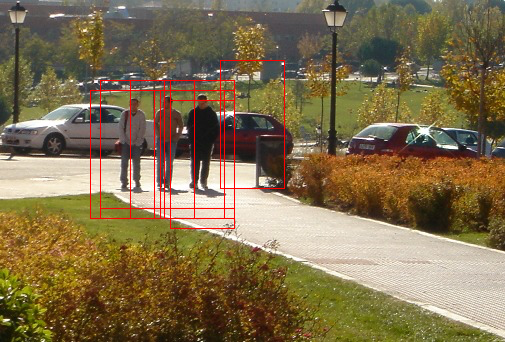

In [46]:
imgres

### TODO

Write `gradients_to_bins` as a `generated_function` in order to speed up the calls.
This will avoid

- Computing `upper_bin_limit += bin_width` at runtime (it willb e done at compile time)
- It should allocate 0 bytes when running


#### About number of times a percep.predict is applied

In [47]:
n_row_image, n_col_image = size(image)
n_evaluations_per_row = ceil((n_row_image - patch_size[1])/10)
n_evaluations_per_col = ceil((n_col_image - patch_size[2])/10)
n_row_image, n_col_image = size(img)

(342, 505)

In [48]:
n_evaluations_per_row * n_evaluations_per_col

0.0

In [49]:
println("number of evaluations of the model: ", length(positions))
println("size of the image: ", size(img))
println("patch size: ", patch_size)
println("stride: ", stride)

number of evaluations of the model: 990
size of the image: (342, 505)
patch size: (128, 64)
stride: 10


## Looping over the hogmap

In [50]:
image = load("tutorial/humans.jpg")
image_hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 
println("size of the image: ", size(image))
println("size of the image_hogmap: ", size(image_hogmap))

size of the image: (342, 505)
size of the image_hogmap: (41, 62, 9)


In [51]:
patch  = negative_patches[1]
patch_hogmap = create_histmap(patch, cell_stride, cell_size, n_bins); 
println("patch size: ", patch_size)
println("size of the patch_hogmap: ", size(patch_hogmap))
println("number of elements patch_hogmap: ", length(patch_hogmap))

patch size: (128, 64)
size of the patch_hogmap: (15, 7, 9)
number of elements patch_hogmap: 945


In [52]:
# A window of (128,64) in the original image corresponds to a (30,14) window in the hogmap space 
length(patch_hogmap) == length(create_descriptor(patch,HOG()))

false

In [53]:
30*8 - 15*8+8, 14*8 - 7*8+8

(128, 64)

In [54]:
patch_hogmap_size =  size(patch_hogmap)[1:2]

(15, 7)

In [55]:
@time image_hogmap[1:patch_hogmap_size[1], 1:patch_hogmap_size[2],:];

  0.066740 seconds (20.57 k allocations: 1.042 MiB)


#### Correspondence of shapes: Original to Hogmap

- Notice that every cell `cell_size x cell_size` gets transformed to a single element  (of size `n_bins`) of the hogmap.
- The above prints suggest that a (128, 64) patch in the original image corresponds to a (30, 14) in the hogmap.
- Notice that the positions from the original image are mapped from the hogmap (THEY ARE PROBABLY WRONG, I HAVE NOT THOUGH A LOT ABOUT THE COORDINATES)

In [56]:
function apply_model_every_patch_hogmap(model, image, cell_stride, cell_size, n_bins, patch_hogmap_size, model_stride)
    y_scores = []
    y_hats = []
    positions = Dict()
    k = 0
    n_rows_patch_hogmap, n_cols_patch_hogmap = patch_hogmap_size   
    hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 
    n_row, n_col, _ = size(hogmap)
    
    @inbounds for i in 1:model_stride:n_row - n_rows_patch_hogmap
        for j in 1:model_stride:n_col - n_cols_patch_hogmap
            descriptor = view(image_hogmap, i:i + n_rows_patch_hogmap-1, j:j + n_cols_patch_hogmap-1, :)
            descriptor = reshape(descriptor, length(descriptor))
            y_hat, y_score  = Perceptron.predict(model, descriptor);
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = ( i*cell_stride-cell_stride, j*cell_stride-cell_stride)
            k = k + 1
        end
    end
    return positions, y_hats, y_scores
end

apply_model_every_patch_hogmap (generic function with 1 method)

In [57]:
cell_stride = 8
cell_size   = 8
n_bins      = 9
model_stride = 2
image = load("tutorial/humans.jpg")
positions, y_hats, y_scores = apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                                             n_bins,  patch_hogmap_size, model_stride);

In [58]:
# This is 20 fps and without multiprocessing!
@time  apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                                            n_bins,  patch_hogmap_size, model_stride);


  0.044186 seconds (50.51 k allocations: 8.154 MiB)


In [59]:
patch_size, sum(y_hats.==2), stride

((128, 64), 4, 10)

In [60]:
pos = []
for (i,s) in enumerate(y_scores)
    if indmax(s).==2
        push!(pos, i)
    end
end

In [61]:
sum(map(indmax,y_scores).==1), sum(map(indmax,y_scores).==2)

(360, 4)

In [62]:
sort([y[2]/y[1] for y in y_scores])

364-element Array{Float64,1}:
 -0.30714 
 -0.298472
 -0.255377
 -0.235748
 -0.226508
 -0.212671
 -0.206784
 -0.187745
 -0.185369
 -0.178705
 -0.171339
 -0.162237
 -0.151928
  ⋮       
  0.62474 
  0.66554 
  0.752339
  0.759434
  0.803301
  0.821185
  0.82908 
  0.831266
  1.12824 
  1.57485 
  3.56569 
  5.64077 

In [63]:
n_row_patch, n_col_patch = patch_size

(128, 64)

In [64]:
pedestrians_detections = pos
imgres = deepcopy(img)
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    imgres[x:x+n_row_patch,y] = c(1,0,0)                  # Left vertical bar
    imgres[x:x+n_row_patch,y+n_col_patch] = c(1,0,0)      # Right vertical bar
    imgres[x,y:y+n_col_patch] = c(1,0,0)                  # Top horizontal bar
    imgres[x+n_row_patch,y:y+n_col_patch] = c(1,0,0)      # Bottom horizontal bar
end

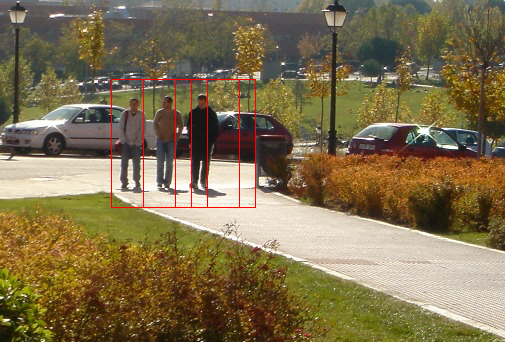

In [65]:
imgres

### Visuallize hogmap

In [66]:
image_gray = to_gray(image);

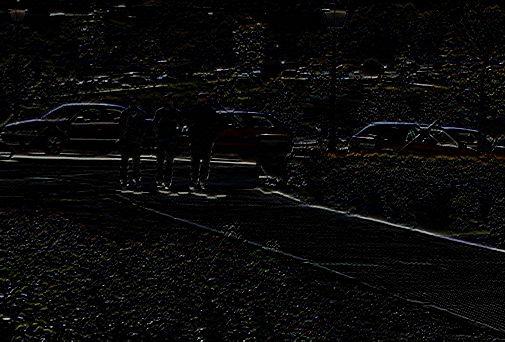

In [67]:
aux = imfilter(image, centered([-1 0 1]'))

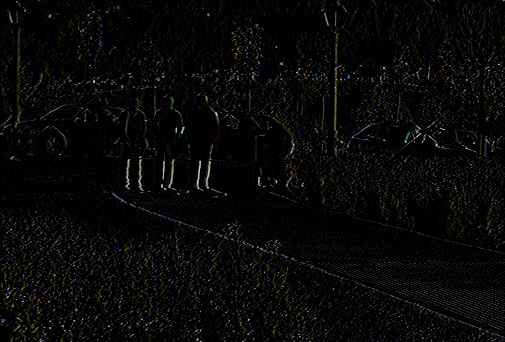

In [68]:

imfilter(image, centered([-1 0 1]))

In [69]:
hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 

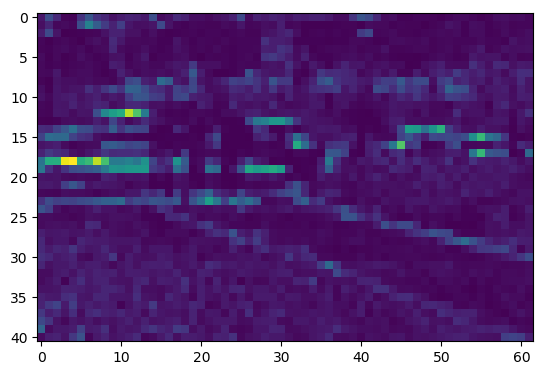

PyObject <matplotlib.image.AxesImage object at 0x10e4e4f60>

In [70]:
imshow(hogmap[:,:,5])

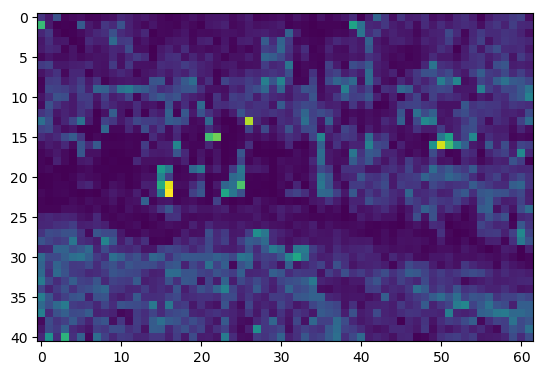

PyObject <matplotlib.image.AxesImage object at 0x135efc748>

In [71]:
imshow(hogmap[:,:,2])

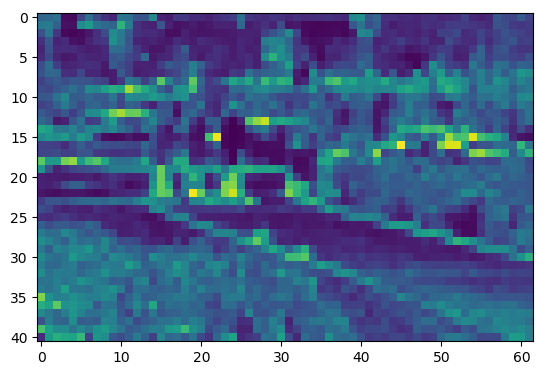

PyObject <matplotlib.image.AxesImage object at 0x1362e8390>

In [72]:
imshow(mean(hogmap,3)[:,:,1])

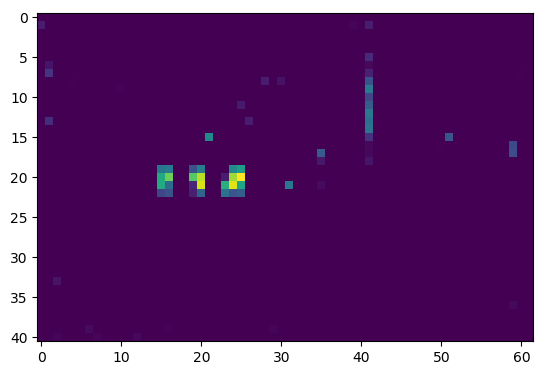

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] max(::Array{Float64,3}, ::Int64) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/david.buchaca/.julia/v0.6/IJulia/src/execute_request.jl:180
 [5] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/david.buchaca/.julia/v0.6/Compat/src/Compat.jl:332
 [6] eventloop(::ZMQ.Socket) at /Users/david.buchaca/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##15#18)() at ./task.jl:335
while loading In[73], in expression starting on line 1


PyObject <matplotlib.image.AxesImage object at 0x136388860>

In [73]:
imshow(max(hogmap,3)[:,:,1])

### Parallelizing parts of the code